# Dragon 5 Snow Water Equivalent Tutorial

Welcome! I am Dr. Mel Sandells and look forward to working with you on development of Snow Water Equivalent retrievals from passive microwave data. We will use the Snow Microwave Radiative Transfer (SMRT) model to investigate the sensitivity of microwave emission to snow properties and develop your own SWE retrieval algorithm. We will then apply this to ground-based data and see how well your retrieval algorithm compares with measured data.

In this tutorial, we will:
- Use the Chang algorithm to calculate SWE
- Compare with observations of snow mass
- Simulate microwave emission with SMRT and re-derive the Chang algorithm
- Explore sources of error due to snowpack properties


We will use the SMRT model and field observations from the Dai papers below with python and jupyter notebooks. The field campaign took place between 27 November 2015 to 25 March 2016 at the Altay National Reference Meteorological station (ANRMS), which is approximately 6 km from the foot of the Altay Mountains in Northwest China.

Dai, L. (2020). Microwave radiometry experiment for snow in Altay China: in situ time series of data for electromagnetic and physical features of snow pack and environment. National Tibetan Plateau / Third Pole Environment Data Center. https://doi.org/10.11888/Snow.tpdc.270886.

Dai, L.Y., Che, T., Xiao, L.et al. (2022) Improving the snow volume scattering algorithm in a microwave forward model by using ground-based remote sensing snow observation. IEEE Transactions on Geoscience and Remote Sensing, 60, 4300617

Dai, L., Che, T., Zhang, Y., Ren, Z., Tan, J., Akynbekkyzy, M., Xiao, L., Zhou, S., Yan, Y., Liu, Y., Li, H., and Wang, L. (2022). Microwave radiometry experiment for snow in Altay, China: time series of in situ data for electromagnetic and physical features of snowpack. Earth Syst. Sci. Data, 14, 3509–3530, doi: 10.5194/essd-14-3509-2022.


## Use Chang algorithm to calculate SWE

The 'Chang algorithm' is often quoted as

SWE (mm) = 4.77 * (TB18H - TB36H)

where the horizontally polarized brightness temperatures at 18 GHz (TB18H) and 36 GHz (TB36H) are in Kelvin (refs). However, if you go back to the original paper, equation 1 of Chang et al. (1987) states that

SD = 1.59 * (TB18H - TB36H) cm.

There is already an assumption that has been applied to convert snow depth (SD) in cm to SWE in mm. What is the density that has been assumed?

mass = density * volume

SWE [kg m<sup>-2</sup>] = density * SD [m]

Note: SWE units of mm are equivalent to kg m<sup>-2</sup>: use density of liquid water = 1000 kg m<sup>-2</sup> over 1 m<sup>3</sup> volume in the equation above.


In [1]:
# Calculate assumed density. First convert Chang and SWE coefficients into SI units.

density = 4.77 * 1e3 / (1.59 * 10)
print (density)


300.0


So there is already an assumption that all snow has a density of 300 kg m<sup>-2</sup>. This is named in the Chang paper, Chang, A., Foster, J., & Hall, D. (1987). Nimbus-7 SMMR Derived Global Snow Cover Parameters. Annals of Glaciology, 9, 39-44. doi:10.3189/S0260305500200736 so that's good. 

Let's have a look at some measured data from Dai, L. (2020). Microwave radiometry experiment for snow in Altay China: in situ time series of data for electromagnetic and physical features of snow pack and environment. National Tibetan Plateau / Third Pole Environment Data Center. https://doi.org/10.11888/Snow.tpdc.270886. These data have already been downloaded for you so let's load them. They are in netCDF format so we will import a package to read them, along with some other standard packages for analysis and plotting.

In [2]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Read snowpit data
ds_snow = xr.open_dataset('Dragon5DataSnowSWE/daily_snow_pit_data.nc')
# See what's inside
print (list(ds_snow.keys()))

['Snow depth', 'long_layer1', 'short_layer1', 'thickness_layer1', 'long_layer2', 'short_layer2', 'thickness_layer2', 'long_layer3', 'short_layer3', 'thickness_layer3', 'long_layer4', 'short_layer4', 'thickness_layer4', 'long_layer5', 'short_layer5', 'thickness_layer5', 'long_layer6', 'short_layer6', 'thickness_layer6', 'Snow Tube', 'snow fork_5 cm', 'snow fork_10 cm', 'snow fork_15 cm', 'snow fork_20 cm', 'snow fork_25 cm', 'snow fork_30 cm', 'snow fork_35 cm', 'snow fork_ 40 cm', 'snow fork_45 cm', 'snow fork_50 cm', 'snow shovel_0-10 cm', 'snow shovel_10-20 cm', 'snow shovel_20-30 cm', 'snow shovel_30-40 cm', 'snow shovel_40-50 cm', 'shape_layer1', 'shape_layer2', 'shape_layer3', 'shape_layer4', 'shape_layer5', 'shape_layer6']


There are a lot of variables in this dataset! For now, we'll look at the density integrated over the whole snowpack. This is the 'Snow Tube' variable, which has units of g cm<sup>-3</sup> in the input file (see readme.docx in the Dragon5DataSnowSWE folder). We'll convert it to SI units and plot it as a function of time.

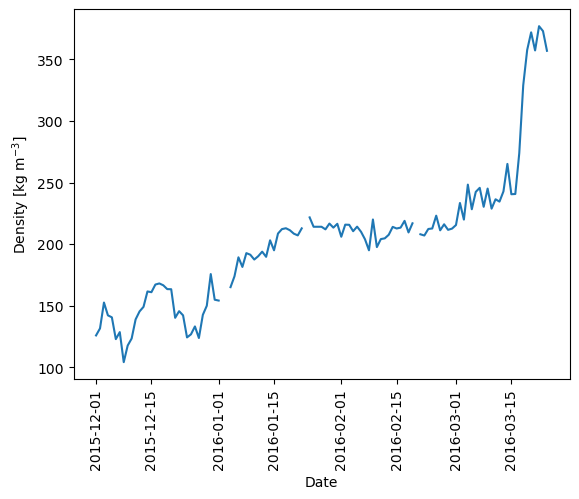

In [4]:
plt.plot(ds_snow['time'].values, ds_snow['Snow Tube'].values*1e3)
plt.xlabel('Date')
plt.ylabel('Density [kg m$^{-3}$]')
plt.xticks(rotation=90)
plt.show()

When do you think the algorithm might work best? Is it a good algorithm?

Next, we'll create a new variable to store SWE

In [5]:
# SWE in mm = depth in m * density in kg m-3
SWE_mm = (ds_snow['Snow depth'].values / 100) * ds_snow['Snow Tube'].values * 1e3

Plot SWE vs time to show what you hope the algorithm will be able to retrieve. You can also plot SWE vs depth.

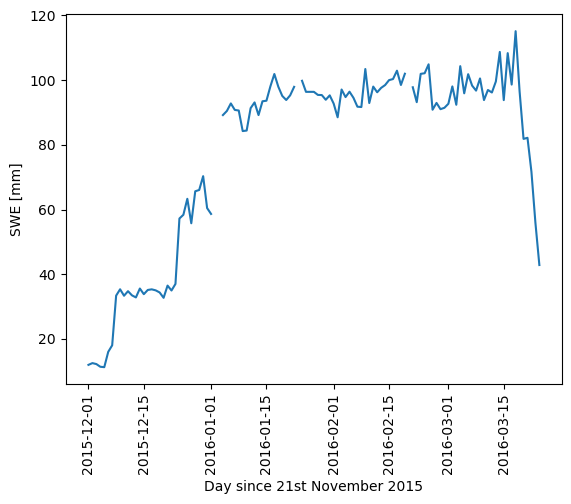

In [6]:
# Delete this
plt.plot(ds_snow['time'].values, SWE_mm)
plt.xlabel('Day since 21st November 2015')
plt.ylabel('SWE [mm]')
plt.xticks(rotation=90)
plt.show()

We'll load in the in-situ measured brightness temperature. Note that the Chang algorithm was designed to work at an incidence angle of 50 degrees. We will select all data between 45 and 55 deg incidence angle.

In [7]:
tb_data = xr.open_dataset('Dragon5DataSnowSWE/TBdata-multianglen.nc')
mask = (tb_data['incidence angle'].values > -55) & (tb_data['incidence angle'].values < -45)
tb_final = tb_data.sel(time=mask)

Now we perform the Chang retrieval algorithm on these data

In [8]:
Chang_swe = 4.77 * (tb_final.Tb18h - tb_final.TB36h)

Note the change in naming convention between frequencies (Tb or TB). When developing a dataset, you can save yourself time with consistent naming - this makes it easier to automate the code.

## Compare with observations of snow mass


Plot both Chang_swe and measured SWE against time

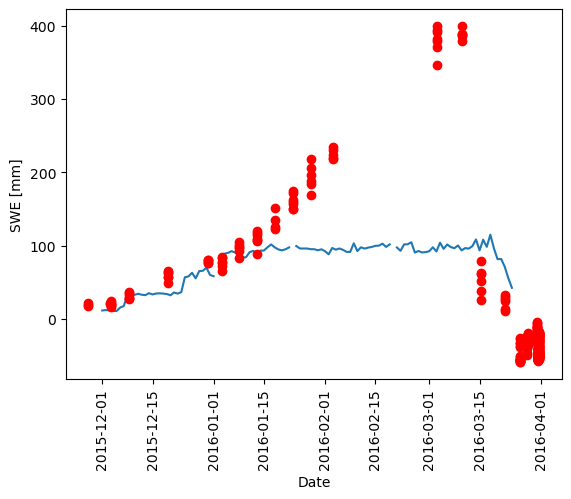

In [9]:
# Delete this
plt.plot(ds_snow['time'].values, SWE_mm)
plt.plot(tb_final.time, Chang_swe, 'ro')
plt.xlabel('Date')
plt.ylabel('SWE [mm]')
plt.xticks(rotation=90)
plt.show()

What do you think of the algorithm performance? When does it work the best? 

## Simulate microwave emission with SMRT and re-derive the Chang algorithm

We are trying to recreate this figure:

<img src="Dragon5DataSnowSWE/Chang.png" width="400">

In [10]:
# A few SMRT imports to help you build the snowpack, sensor, substrate and model
from smrt import make_model, make_snowpack, sensor_list, make_soil

In [11]:
# Make a simple snowpack
radius = 0.3e-3
density= 300
temperature = 260
sp = make_snowpack(thickness=[1], microstructure_model='sticky_hard_spheres',
                  density=density, radius=radius, temperature=temperature,
                  stickiness=0.15)

# Make a simple soil underneath
soil = make_soil('soil_wegmuller', 'dobson85', temperature=265, roughness_rms=0.25, 
                 moisture=0.25, sand=0.01, clay=0.7, drymatter=1300)

In [12]:
# Put the snow on top of the soil
snow = sp + soil

If we wanted to, we could make an atmosphere and add it with 

```snow = atmos + sp + soil```

or put snow on top of sea ice e.g.

```medium = sp + sea_ice```

For now, we will stick with snow on top of soil, but SMRT tutorials are available on https://github.com/smrt-model/tutorials for atmosphere and sea ice.


Now we specify the model configuration. We need to choose an electromagnetic model (Here, the Improved Born Approximation model 'iba') and a method to solve the radiative transfer equation (here, the Discrete Ordinates Radiative Transfer solver 'dort')

In [13]:
# Make model
model = make_model("iba", "dort")

Next, we need to specify the sensor. We have several pre-built sensors available e.g. CryoSat-2, AMSRE but we'll use the generic passive sensor as this is unique to the field campaign. If you want, you can expand the frequency list to include the field measurements, or incidence angle list to look at different incidence angles. Here we will look at two frequencies and one incidence angle. NOTE: all inputs to SMRT are in SI units with no exceptions. Frequencies will be in Hz, not GHz.

In [14]:
frequencies = [18e9, 36e9]
incidence_angle = 50

radiometer = sensor_list.passive(frequencies, incidence_angle)

Now we run the model for the sensor looking at the snowpack and look at the results

In [15]:
results = model.run(radiometer, snow)
print (results.TbH().values)

[248.7399872  212.81890392]


Note that the brightness temperature at 18 GHz is higher than 36 GHz. Why do you think this is?


SMRT can also be run in active (simulate backscatter) or altimeter mode (simulate altimeter waveform). For active, you can simply specify a different sensor e.g.

``` 
scatterometer = sensor_list.active(frequencies, incidence_angle)
active_results = model.run(scatterometer, sp)
print (active_results. sigmaHH_dB()) 
```

Here we have not specified a substrate because the soil model used is for passive. The model has only been run for the snow. You may get a warning that the snowpack is too thin: this indicates radiation may be lost at the bottom of the snowpack. Details on how to use an active model are included in the SMRT Tutorials on GitHub.

For altimeter results, you need a time-dependent radiative transfer solution technique so would have to change the model e.g. 

``` 
altimeter_model = make_model('iba', 'nadir_lrm_altimetry')
from smrt.inputs.altimeter_list import sentinel3_sral
s3 = sentinel3_sral()
altimeter_result = altimeter_model.run(s3, sp)
plt.plot(altimeter_result.t_gate*1e9, altimeter_result.sigma())
```

To recreate the Chang algorithm we need to specify brightness temperatures for a range of SWE. We will generate a list of snowpacks and run the model on them. The maximum SWE in the Chang algorithm is 100cm (1000mm). With a snow density of 300 kg m$^{-3}, this is equivalent to a snow depth of 3.3m. We will generate an array of snowdepths up to 3.4 m in increments of 0.1m

In [16]:
snowdepths = np.arange(0.1, 3.5, 0.1)

Use *list comprehension* to generate a list of snowpacks! Then check the parameters are as you expect.

In [17]:
snowpacks = [make_snowpack(thickness=[d], microstructure_model='sticky_hard_spheres',
                  density=density, radius=radius, temperature=temperature,
                  stickiness=0.15) + soil for d in snowdepths]

In [18]:
# Print first snowpack in the list (index is 0). If you want to plot the last snowpack in the list, use index = -1.
snowpacks[0]

Snowpack:       layer                                                                 \
  thickness microstructure_model density temperature liquid_water salinity   
0       0.1    StickyHardSpheres   300.0       260.0          0.0      0.0   
s       NaN                  NaN     NaN         NaN          NaN      NaN   

  microstructure                    interface      substrate                
     frac_volume  radius stickiness      name           name roughness_rms  
0       0.327261  0.0003       0.15      Flat            NaN           NaN  
s            NaN     NaN        NaN       NaN  SoilWegmuller          0.25

Now run the passive model with the radiometer sensor on a list of snowpacks and plot the results for 18 GHz

In [19]:
results_all = model.run(radiometer, snowpacks)

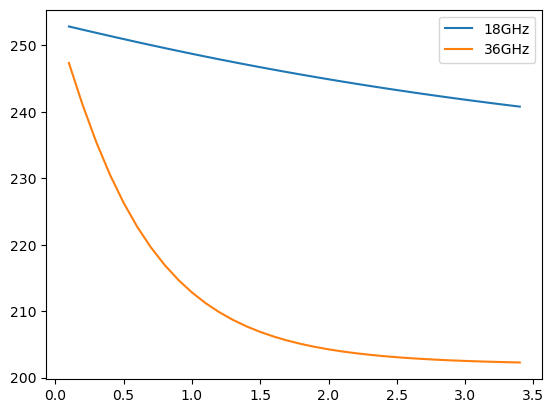

In [20]:
plt.plot(snowdepths, results_all.TbH(frequency=18e9), label='18GHz')
# Definitely delete
plt.plot(snowdepths, results_all.TbH(frequency=36e9), label='36GHz')
plt.legend()

Now add in the 36GHz results to the graph above and add axes labels and a legend ```plt.legend()```


It should start to look something like the left hand side Chang figure above. If you wanted to really recreate it, you could expand the list of frequencies and re-run the simulations. You could also generate a second graph with a grain radius of 0.5mm.

The Chang algorithm is based on the brightness temperature difference: for simplicity let's plot this brightness temperature difference against depth, find the slope of the graph and hopefully find the 1.59 coefficient in the original Chang algorithm.

In [21]:
#tb_diff = 
# delete:
tb_diff = results_all.TbH(frequency=18e9) - results_all.TbH(frequency=36e9)

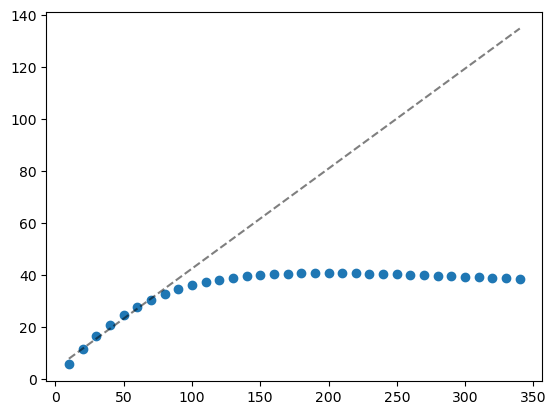

In [22]:
# Use a scatterplot
plt.scatter(snowdepths*1e2, tb_diff)
# Add axes labels

# Delete
fit = np.polyfit(snowdepths[0:8]*1e2, tb_diff[0:8], deg=1)
plt.plot(snowdepths*1e2, fit[0] * snowdepths*1e2 + fit[1], 'k--', alpha=0.5)

Why does the graph look like this? What is happening in deeper snow? How would you fit a best-line fit to this? Note that the algorithm should run close to the origin i.e. no difference in brightness temperature means snow snow.

Use ```fit = np.polyfit(snowdepths[0:2]*1e2, tb_diff[0:2], deg=1)``` but think about what range you would like to apply this over. This code will only fit to the first two values.


Add the fitted line to the graph above with this code:
```plt.plot(snowdepths, fit[0] * snowdepths + fit[1], 'k--', alpha=0.5)```

The gradient (coefficient) is then the fit[0] parameter. What is your coefficient?


In [23]:
print (fit[0])

0.3853745410556581


Does it equal 1.59? Why not? What about for a grain radius of 0.5mm? How do you think the Chang algorithm was derived?

In [24]:
# Delete
snowpacks = [make_snowpack(thickness=[d], microstructure_model='sticky_hard_spheres',
                  density=density, radius=0.6e-3, temperature=temperature,
                  stickiness=0.15) + soil for d in snowdepths]
results_all = model.run(radiometer, snowpacks)
tb_diff = results_all.TbH(frequency=18e9) - results_all.TbH(frequency=36e9)

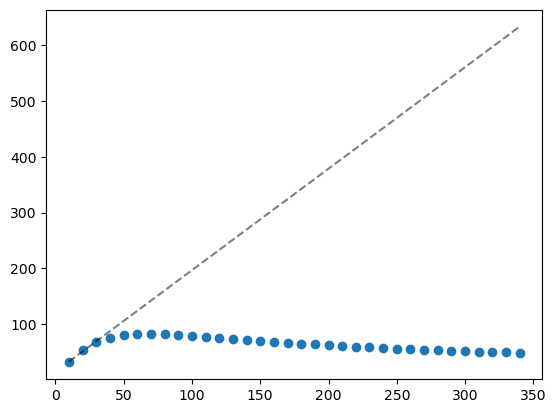

In [25]:
# Delete all
# Use a scatterplot
plt.scatter(snowdepths*1e2, tb_diff)
# Add axes labels

# Delete
fit = np.polyfit(snowdepths[0:3]*1e2, tb_diff[0:3], deg=1)
plt.plot(snowdepths*1e2, fit[0] * snowdepths*1e2 + fit[1], 'k--', alpha=0.5)

So perhaps you have derived an algorithm close to the Chang algorithm, yet the graph you plotted with measured SWE shows a large overestimation for higher SWE. Is the model doing a good job at simulating brightness temperature? Use the measured depths to create a new list of snowpacks for each measurement time.

Note we will need to skip the one snowdepth recorded as NaN. We will use a mask.

In [26]:
# Pick only values that are not NaN
nan_mask = ~np.isnan(ds_snow['Snow depth'].values)

In [27]:
# NB /100 converts from measured units of cm to SI units needed in SMRT
snowpacks_obs_depth = [make_snowpack(thickness=[d], microstructure_model='sticky_hard_spheres',
                  density=density, radius=radius, temperature=temperature,
                  stickiness=0.15) + soil for d in (ds_snow['Snow depth'].values[nan_mask] / 100)]


results_obs_depths = model.run(radiometer, snowpacks_obs_depth)

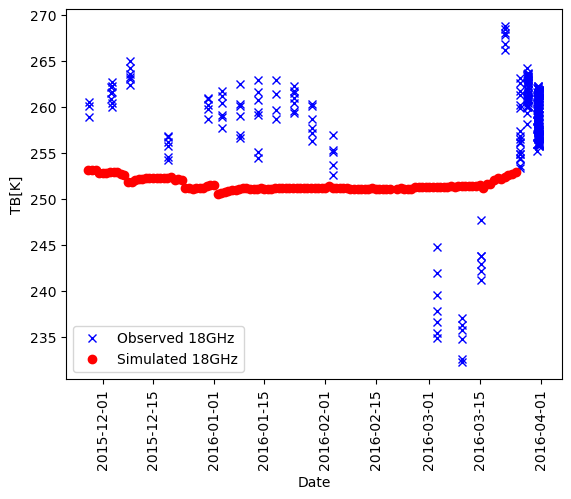

In [28]:
# Plot results
plt.plot(tb_final.time, tb_final.Tb18h, 'bx', label='Observed 18GHz')
plt.plot(ds_snow.time[nan_mask], results_obs_depths.TbH(frequency=18e9), 'ro', label='Simulated 18GHz')
plt.legend()

plt.xlabel('Date')
plt.ylabel('TB[K]')
plt.xticks(rotation=90)
plt.show()

Add in the results for 36 GHz. Do the model results compare well with observations? Why not?


## Explore sources of error due to snowpack properties

How do the snowpack observations compare with what we have assumed? Let's take 3rd February 2016, where the retrieval algorithm doesn't work so well and we have observations of brightness temperature. We'll subset the snow data and look at the multiple layer properties.

In [29]:
selected_date = ds_snow['time'][68].values

snow_3Feb = ds_snow.sel(time=selected_date)

Have a look at the properties of each layer (1-4). Note these may not be in SI units. Temperature information 

In [30]:
print('thickness of layer 1 (cm)', snow_3Feb.thickness_layer1.values)
print('snow density to 5cm (g/cm3)', snow_3Feb['snow fork_5 cm'].values)
print('long axis grain extent in layer 1 (mm)', snow_3Feb['long_layer1'].values)
print('short axis grain extent in layer 1 (mm)', snow_3Feb['short_layer1'].values)

thickness of layer 1 (cm) 4.0
snow density to 5cm (g/cm3) 0.2526
long axis grain extent in layer 1 (mm) 2.48
short axis grain extent in layer 1 (mm) 1.92


Snow temperature data are held in a different file. We'll import it and set the date to the closest observed TB time (3rd Feb)

In [31]:
# Read temperature data
temp_data = xr.open_dataset('Dragon5DataSnowSWE/ten-minute_4_component_radiation_and_snow temperature.nc')
# See what's inside
print (list(temp_data.keys()))

['SR_DOWN', 'SR_UP', 'LR_DOWN', 'LR_UP', 'NR01TK', 'Snow_T_AVG', 'Snow_T_0cm', 'Snow_T_5cm', 'Snow_T_15cm', 'Snow_T_25cm', 'Snow_T_35cm', 'Snow_T_45cm', 'Snow_T_55cm']


In [32]:
print (selected_date)
print (tb_final.time[64].values)
print(temp_data['time'][10540].values)
snow_temperature = temp_data.sel(time=temp_data['time'][10540].values)

2016-02-03T00:00:00.000000000
2016-02-03T04:37:24.000000000
2016-02-03T04:30:00.000000000


In [33]:
# Check temperature at bottom of snowpack
print (snow_temperature.Snow_T_0cm.values)

-1.14


Have a look at the properties of the different layers. We'll need thickness, density, temperature and grain radius. There is a slight complication because the layers follow the natural stratigraphy of the snowpack, the snow fork density measurements and temperatures are made every 5cm, so you'll need to make some modelling assumptions and decide how to deal with this. To simulate a multilayer snowpack with SMRT, just specify lists for each of the parameters. The example with Chang assumed parameters are given below.

In [34]:
thickness_array = [0.04, 0.12, 0.26, 0.03]
density_array = [300, 300, 300, 300]
radius_array = [0.4e-3, 0.4e-3, 0.4e-3, 0.4e-3]
temperature_array = [260, 260, 260, 260]

chang_snowpack = make_snowpack(thickness=thickness_array, microstructure_model='sticky_hard_spheres',
                  density=density_array, radius=radius_array, temperature=temperature_array,
                  stickiness=0.15) + soil

In [35]:
chang_results = model.run(radiometer, chang_snowpack)
print (chang_results.TbH().values)

[248.51133145 205.18653549]


Adapt this example to make a more realistic snowpack. Take care to use SI units! Also SMRT layers are numbered from the top down. The thickness array has been done for you, but you'll need to change the other arrays to be more realistic and based on the observations.

In [36]:
# delete
thickness_array = [0.03, 0.26, 0.12, 0.04]
density_array = [185, 240, 200, 253]
radius_array = [0.7e-3, 0.83e-3, 1.22e-3, 1.1e-3]
temperature_array = [255, 268, 270, 271]

realistic_snowpack = make_snowpack(thickness=thickness_array, microstructure_model='sticky_hard_spheres',
                  density=density_array, radius=radius_array, temperature=temperature_array,
                  stickiness=0.15) + soil

In [37]:
realistic_results = model.run(radiometer, realistic_snowpack)
print (realistic_results.TbH().values)


[200.14625156 108.20315958]


Compare these with the measured values - does knowing more about the snow properties produce better results? Do the better results get it right for the right reason? What other sources of error are there?

In [38]:
print (tb_final.Tb18h[64].values, tb_final.TB36h[64].values)

252.65 203.35
